# Time Series Forecasting
## Task
> Forecast on two last weeks, taking into account yearly and weekly seasonality.

## Task's results
> See fig.1, fig.2

## Content
1. [Data Preprocessing](#Data-Preprocessing)
2. [Data Visualization](#Data-Visualization)
3. [Data Forecasting](#Data-Forecasting)
    - [Approach 1: Neural Network](#Approach-1:-Neural-Network)
    - [Approach 2: Autoregressive model](#Approach-2:-Autoregressive-model)

In [36]:
# Import dependencies
from collections import deque
from math import sqrt

from scipy import stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import torch.nn.functional as F

# Set random seed for result's reproduction
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

## Data Preprocessing

In [37]:
# Read data from a csv file
path_to_data = r"C:\forecast_data.csv"
data = pd.read_csv(path_to_data, sep=',', names=['date', 'y'],
                   skiprows=1, index_col=0, parse_dates=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 917 entries, 2018-04-01 to 2020-10-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       917 non-null    float64
dtypes: float64(1)
memory usage: 14.3 KB


> There is no missing data in 'y' column, nevertheless let's check skipped values in date indexes.  
Create skipped date if it's necessary with value which is equal average between the nearest two the same days of week as skipped date.

In [38]:
skipped_idx = pd.date_range(start=data.index[0], end=data.index[-1] ) \
                .difference(data.index)

if len(skipped_idx) > 0:
    print("Here are skipped dates:")
    for item in skipped_idx:
        print(f"\t {item.day_name()} {item.date().strftime('%Y-%m-%d')}")
        values = []
        
        d = skipped_idx[0] - pd.Timedelta(7, 'd')
        # Check if date exists in indexes
        if d in data.index:
            values.append(data.loc[d])
        
        d = skipped_idx[0] + pd.Timedelta(7, 'd')
        # Check if date exists in indexes
        if d in data.index:
            values.append(data.loc[d])
        
        if len(values) > 0:
            data.loc[item] = np.mean(values)
        else:
            # if the nearest these days of week are not exist
            # use median (as robust estimation to outliers)
            data.loc[item] = np.median(data['y'].values)

data = data.sort_index()  

Here are skipped dates:
	 Saturday 2018-07-14


In [39]:
# Print statistics
print(data.describe())
print(stats.describe(data['y']))

                  y
count    918.000000
mean    7044.568627
std     3832.622951
min      568.000000
25%     4125.500000
50%     6698.500000
75%     9591.750000
max    15351.000000
DescribeResult(nobs=918, minmax=(568.0, 15351.0), mean=7044.568627450981, variance=14688998.681762781, skewness=0.29034140888416515, kurtosis=-0.8839868416938255)


## Data Visualization

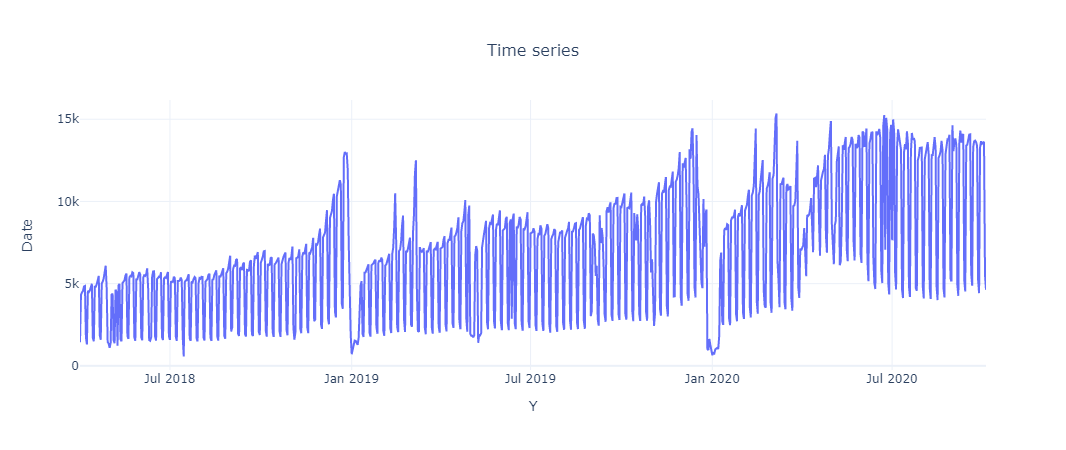

In [55]:
fig = go.Figure(data=[go.Line(
    x=data.index,
    y=data['y']
)])

fig.update_layout(
    title = dict(
        text='Time series',
        font=dict(size=16),
        x=0.5,
        y=0.9,
        xanchor='center',
        yanchor='top'
    ),
    xaxis_title='Y',
    yaxis_title='Date',
    template='plotly_white'
)

fig.show()

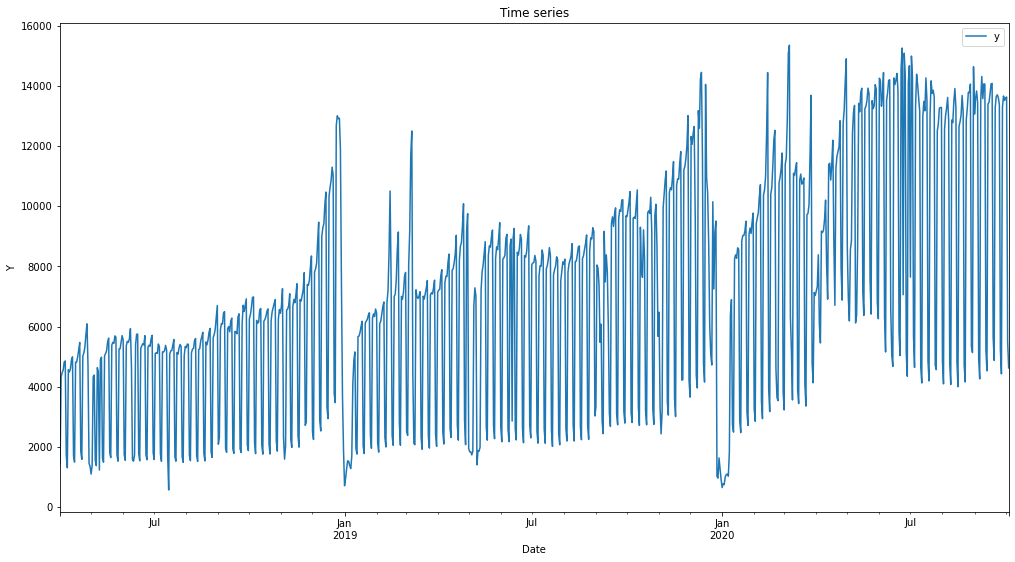

In [5]:
fig, ax = plt.subplots(figsize=(17, 9))
data.plot(ax=ax)
ax.set(title = 'Time series')
ax.set_xlabel('Date')
ax.set_ylabel('Y')
plt.show()

## Data Forecasting

### Approach 1: Neural Network

In [6]:
# Helper function for creating dataset
def create_samples(data, lag=7, data_augmentation=False,
                   n_times=1, mu=0., sigma=50.):
    """Creates input/ output samples according to the following rule:
    If X1, X2, X3, X4, X5, X6, X7, ..., Xn is the time series 
    and 'lag' is 3, so samples wil be:
    X               y
    [X1, X2, X3] -> X4,
    [X2, X3, X4] -> X5,
    ...
    [Xn-3, Xn-2, Xn-1] -> Xn
    """
    
    X = np.zeros((len(data)-lag, lag))
    y = np.zeros(len(data)-lag)
    for i, d in enumerate(data.index[:-lag]):
        X[i, :] = data[d: d+pd.Timedelta(lag-1, 'd')]['y'].values
        y[i] = data.loc[d+pd.Timedelta(lag, 'd')]['y']
    
    if data_augmentation:
        for i in range(n_times):
            noise_X = np.random.normal(mu, sigma, size=X.shape)
            augment_X = np.clip(X + noise_X, a_min=0, a_max=None)
            X = np.concatenate((X, augment_X), axis=0)
            
            noise_y = np.mean(noise_X, axis=1)
            augment_y = np.clip(y + noise_y, a_min=0, a_max=None)
            y = np.concatenate((y, augment_y), axis=0)

    return X, y

> Let's divide data into training, validation and test sets.  
The last two weeks should be used for testing, so they are kept unseen for training stage.

In [8]:
# Declare constants
lag = 7  # size of sliding window, in days
fc_period = 14  # forecasting period, in days
val_period = 21  # period for validation, in days
batch_size = 24  # batch size for DataLoader

train_data = data[:data.index[-1] - pd.Timedelta(fc_period, 'd') - pd.Timedelta(val_period, 'd')] \
                .copy()

val_data = data[data.index[-1] - pd.Timedelta(fc_period-1, 'd') - pd.Timedelta(val_period, 'd') \
                :data.index[-1] - pd.Timedelta(fc_period, 'd')].copy()

test_data = data[data.index[-1] - pd.Timedelta(fc_period-1, 'd'):].copy()

X_train, y_train = create_samples(train_data, lag, data_augmentation=False)
X_val, y_val = create_samples(val_data, lag, data_augmentation=False)

# Create Dataloaders for neural network
train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float),
    torch.tensor(y_train, dtype=torch.float)
)

val_ds = TensorDataset(
    torch.tensor(X_val, dtype=torch.float),
    torch.tensor(y_val, dtype=torch.float)
)

train_loader = DataLoader(train_ds, batch_size=24, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=24, shuffle=True)

# Show test data just for checking accuracy
print("Test data:")
test_data

Test data:


,y
date,
2020-09-21,13288.0
2020-09-22,13650.0
2020-09-23,13701.0
2020-09-24,13610.0
2020-09-25,13378.0
2020-09-26,5217.0
2020-09-27,4425.0
2020-09-28,13291.0
2020-09-29,13663.0


In [9]:
# MLP - multilayer perceptron
class MLPRegression(nn.Module):
    
    def __init__(self):
        super(MLPRegression, self).__init__()
        
        self.linear = nn.Linear(lag, 32)
        self.linear2 = nn.Linear(32, 48)
        self.linear3 = nn.Linear(48, 16)
        self.linear4 = nn.Linear(16, 1)
    
    
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

In [10]:
# CNN - convolutional neural network
class CNNRegression(nn.Module):
    
    def __init__(self):
        super(CNNRegression, self).__init__()
        self.conv1 = nn.Conv1d(1, 24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(24, 48, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.drop = nn.Dropout2d(p=0.2)
        self.linear1 = nn.Linear(48*3, 64)
        self.linear2 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = x.view(-1, 1, lag)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        #x = self.drop(x)
        x = F.relu(self.conv2(x))
        #x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [11]:
# Helper function to train model
def train(model, criterion, optimizer, data_loader, device):
    model.train()
    train_loss = 0
    for samples, targets in data_loader:
        optimizer.zero_grad()
        samples, targets = samples.to(device), targets.to(device)
        output = model.forward(samples)
        loss = criterion(torch.squeeze(output), targets)
        train_loss += loss.item() * len(samples)
        loss.backward()
        optimizer.step()
    else:
        train_loss /= len(data_loader.dataset)
    
    return train_loss


# Helper function to validate model
def val(model, criterion, data_loader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for samples, targets in data_loader:
            samples, targets = samples.to(device), targets.to(device)
            output = model.forward(samples)
            loss = criterion(torch.squeeze(output), targets)
            val_loss += loss.item() * len(samples)
        else:
            val_loss /= len(data_loader.dataset)
    
    return val_loss

In [12]:
device = "cuda" if torch.cuda.is_available else "cpu"
models = {'MLP': MLPRegression().to(device), 'CNN': CNNRegression().to(device)}
criterion = nn.MSELoss()

epochs = 25  # number of training epochs

for name, model in models.items():
    # Train and validate model
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
    print(f"Model name: {name}")
    for epoch in range(epochs):
        train_loss = train(model, criterion, optimizer, train_loader, device)
        val_loss = val(model, criterion, val_loader, device)
        scheduler.step()
        print(f"Epoch {epoch+1} | train loss: {train_loss:.5f} | val loss: {val_loss:.5f}")
    
    # Calculate predictions
    # For it take the last values (equal lag's value) before test period
    y_hat = deque(
        data[data.index[-1] - pd.Timedelta(fc_period-1, 'd') - pd.Timedelta(lag, 'd') \
                    :data.index[-1] - pd.Timedelta(fc_period, 'd')]['y'].values,
        maxlen=lag
    )
    
    # Predict new value and put it at the end of queue
    # So this new value will participate for next prediction
    # It looks like (let for example lag=3 be):
    # Xn-3, Xn-2, Xn-1 -> predict new value Y1
    # Xn-2, Xn-1, Y1 -> predict new value Y2
    # Xn-1, Y1, Y2 -> predict new value Y3
    # and so on...
    result = []
    for _ in range(fc_period):
        prediction = model.forward(torch.tensor(y_hat, dtype=torch.float).unsqueeze(0).to(device)) \
                            .item()
        result.append(prediction)
        y_hat.append(prediction)

    test_data['y_' + name] = result

print("Test data:")
test_data

Model name: MLP
Epoch 1 | train loss: 17518484.57534 | val loss: 7148608.50000
Epoch 2 | train loss: 3612674.40411 | val loss: 1182782.50000
Epoch 3 | train loss: 3009080.29966 | val loss: 673440.68750
Epoch 4 | train loss: 2714846.07192 | val loss: 523695.31250
Epoch 5 | train loss: 2582401.27055 | val loss: 327408.34375
Epoch 6 | train loss: 2472578.98630 | val loss: 1552932.87500
Epoch 7 | train loss: 2381868.20890 | val loss: 296499.81250
Epoch 8 | train loss: 2320386.27825 | val loss: 193708.53125
Epoch 9 | train loss: 2205763.41353 | val loss: 351578.37500
Epoch 10 | train loss: 2174189.74658 | val loss: 385943.71875
Epoch 11 | train loss: 2130378.49229 | val loss: 181914.35938
Epoch 12 | train loss: 2074635.99743 | val loss: 486127.65625
Epoch 13 | train loss: 2207087.02997 | val loss: 200496.15625
Epoch 14 | train loss: 2085605.71575 | val loss: 215336.57812
Epoch 15 | train loss: 2116160.76284 | val loss: 147671.93750
Epoch 16 | train loss: 2014361.60852 | val loss: 138847.953

RMSE for y_MLP: 1579.8464
RMSE for y_CNN: 882.0198


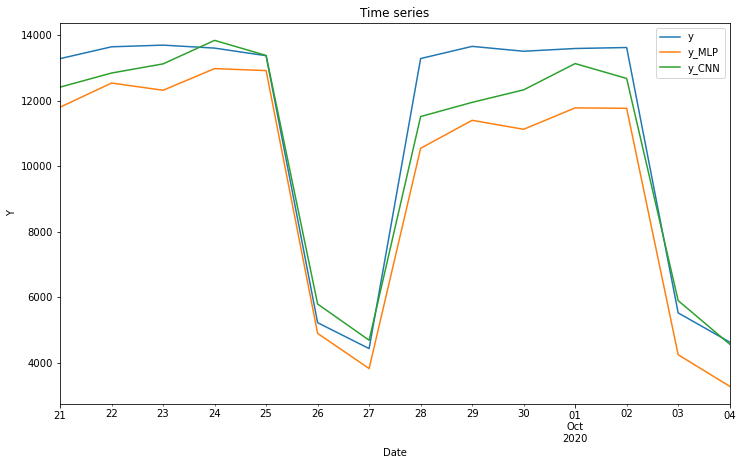

In [13]:
# Print RMSE - root mean squared error
for name in test_data.columns[1:]:
    print(
        f"RMSE for {name}: {sqrt(mean_squared_error(test_data['y'], test_data[name])):.4f}"
    )

fig, ax = plt.subplots(figsize=(12, 7))
test_data.plot(ax=ax)
ax.set(title='Time series')
ax.set_xlabel('Date')
ax.set_ylabel('Y')
plt.show()

### Approach 2: Autoregressive model

In [22]:
# Declare constants
fc_period = 14  # forecasting period, in days

train_data = data[:data.index[-1] - pd.Timedelta(fc_period, 'd')].copy()
test_data = data[data.index[-1] - pd.Timedelta(fc_period-1, 'd'):].copy()

In [32]:
predictor = SARIMAX(
    train_data['y'],
    order=(2, 1, 4),
    seasonal_order=(0, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
    trend=[1, 1, 0, 0],
    freq='D'
).fit()
test_data['y_SARIMAX'] = predictor.forecast(steps=len(test_data)).values
print("Test data:")
test_data

c:\users\se.vi.dmitriev\projects\projects_sandbox\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Test data:


c:\users\se.vi.dmitriev\projects\projects_sandbox\venv\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,y,y_SARIMAX
date,,
2020-09-21,13288.0,13215.576164
2020-09-22,13650.0,13660.082882
2020-09-23,13701.0,13557.947846
2020-09-24,13610.0,14123.258312
2020-09-25,13378.0,13695.554759
2020-09-26,5217.0,5896.861545
2020-09-27,4425.0,5132.457388
2020-09-28,13291.0,13351.261428
2020-09-29,13663.0,13859.785720


RMSE for y_SARIMAX: 405.6347


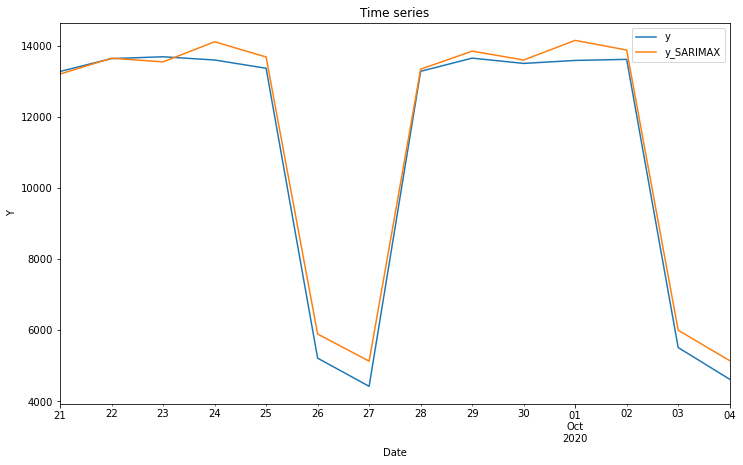

In [33]:
# Print RMSE - root mean squared error
for name in test_data.columns[1:]:
    print(
        f"RMSE for {name}: {sqrt(mean_squared_error(test_data['y'], test_data[name])):.4f}"
    )

fig, ax = plt.subplots(figsize=(12, 7))
test_data.plot(ax=ax)
ax.set(title='Time series')
ax.set_xlabel('Date')
ax.set_ylabel('Y')
plt.show()